In [1]:
import math
import numpy as np
import pandas as pd
np.random.seed(123)

def circulo(num_datos = 100,R = 1, minimo = 0,maximo= 1, center_x = 0 , center_y = 0):
    pi = math.pi
    r = R * np.sqrt(np.random.uniform(minimo, maximo, size = num_datos)) 
    theta = np.random.uniform(minimo, maximo, size= num_datos) * 2 * pi

    x = center_x + np.cos(theta) * r
    y = center_y + np.sin(theta) * r

    x = np.round(x,3)
    y = np.round(y,3)

    df = np.column_stack([x,y])
    df = pd.DataFrame(df)
    df.columns = ['x','y']
    return(df)

# Create data
datos_1 = circulo(num_datos = 20,R = 10, center_x = 5, center_y = 30)
datos_2 = circulo(num_datos = 20,R = 10, center_x = 20, center_y = 10)
datos_3 = circulo(num_datos = 20,R = 10, center_x = 50, center_y = 50)

data = datos_1.append(datos_2).append(datos_3)
data.head()

,x,y
0,-0.542,23.761
1,8.129,25.661
2,4.239,25.298
3,-0.691,25.230
4,3.539,21.645


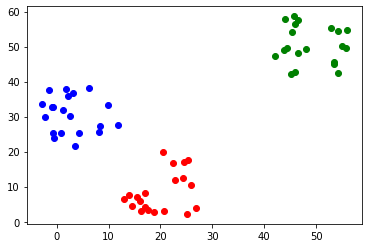

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(datos_1['x'], datos_1['y'], c = 'b')
plt.scatter(datos_2['x'], datos_2['y'], c = 'r')
plt.scatter(datos_3['x'], datos_3['y'], c = 'g')
plt.show()

In [3]:
def initialize_centroids(k, data):

    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = []

    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)

    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids

centroids = initialize_centroids(3, data)
centroids

,x,y
0,52.833388,9.953092
1,15.168107,29.151304
2,52.622571,57.644971


In [4]:
def calculate_error(a,b):
    '''
    Given two Numpy Arrays, calculates the root of the sum of squared errores.
    '''
    error = np.square(np.sum((a-b)**2))

    return error 

In [5]:
errors = np.array([])
for centroid in range(centroids.shape[0]):
    error = calculate_error(centroids.iloc[centroid, :2], data.iloc[0,:2])
    errors = np.append(errors, error)

errors

array([ 9239109.47028511,    76100.30291143, 15797406.01662303])

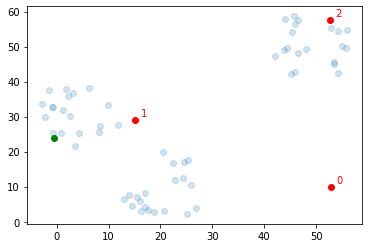

In [6]:
plt.scatter(data.iloc[1:,0], data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(data.iloc[0,0], data.iloc[0,1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i], c = 'r')

In [7]:
np.where(errors == np.amin(errors))[0].tolist()[0]

1

In [8]:
def assign_centroid(data, centroids):
    '''
    Receives a dataframe of data and centroids and returns a list assigning each observation a centroid.
    data: a dataframe with all data that will be used.
    centroids: a dataframe with the centroids. For assignment the index will be used.
    '''

    n_observations = data.shape[0]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]


    for observation in range(n_observations):

        # Calculate the errror
        errors = np.array([])
        for centroid in range(k):
            error = calculate_error(centroids.iloc[centroid, :2], data.iloc[observation,:2])
            errors = np.append(errors, error)

        # Calculate closest centroid & error 
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # Assign values to lists
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign,centroid_errors)

data['centroid'], data['error'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'error']].head()

,centroid,error
0,1,76100.302911
1,1,3810.746835
2,1,18034.697838
3,1,71229.148068
4,1,36703.174251


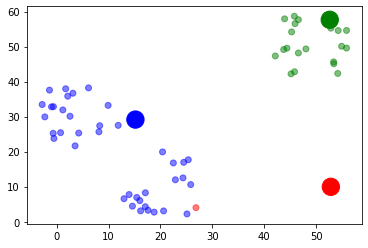

In [9]:
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [10]:
data['error'].sum()

7089622.406081449

In [11]:
data_columns = ['x','y']

centroids = data.groupby('centroid').agg('mean').loc[:,data_columns].reset_index(drop = True)
centroids

,x,y
0,26.831000,4.002000
1,10.902256,19.928974
2,48.898800,50.526050


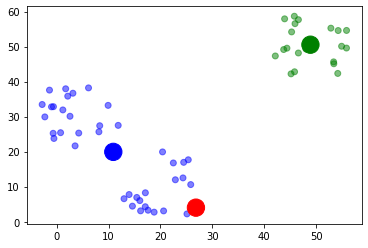

In [12]:
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [13]:
def knn(data, k):
    '''
    Given a dataset and number of clusters, it clusterizes the data. 
    data: a DataFrame with all information necessary
    k: number of clusters to create
    '''

    # Initialize centroids and error
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error.append(sum(iter_error))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i = i + 1 

    data['centroid'], iter_error = assign_centroid(data,centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)
    return (data['centroid'], iter_error, centroids)

In [14]:
data['centroid'], _, centroids =  knn(data.drop(['centroid','error'], axis = 1),3)
data['centroid'].head()  

0    0
1    0
2    0
3    0
4    0
Name: centroid, dtype: int64

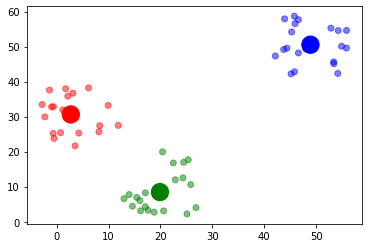

In [15]:
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [16]:
num_trials = 10

classifications = []
errors = []
centroids = []

for i in range(num_trials):

    np.random.seed(i)

    iter_class, iter_error, iter_centroid = knn(data.drop(['centroid','error'], axis = 1),4)

    classifications.append(iter_class)
    errors.append(sum(iter_error))
    centroids.append(iter_centroid)

errors

[147152.52660921525,
 151349.9674395905,
 120104.79154843351,
 175816.14665013814,
 2997534.4064878933,
 175816.14665013814,
 175816.14665013814,
 143211.17155071974,
 137223.97752003098,
 120104.79154843351]

In [20]:
errors = np.array(errors)
best_ind = np.where(errors == errors.min())[0].tolist()[0]

data['centroid'] = classifications[best_ind]

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids[best_ind].iloc[:,0], centroids[best_ind].iloc[:,1],  marker = 'o', s=300, c = centroids[best_ind].index.map(lambda x: colors[x]))


KeyError: 3

In [19]:
_, _, centroids =  knn(data.drop(['centroid','error'], axis = 1),5)
centroids

,x,y
0,17.858923,4.812923
1,2.706850,30.615250
2,23.673714,15.194143
3,48.898800,50.526050


In [21]:
import warnings

def knn(data, k):
    '''
    Given a dataset and number of clusters, it clusterizes the data. 
    data: a DataFrame with all information necessary
    k: number of clusters to create
    '''

    # Initialize centroids
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error = np.append(error, sum(iter_error))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Re initialize centroids
        if(centroids.shape[0] < k):
            warnings.warn("Cluster devanished! Consider reducing the number of k")
            #raise Warning("Vanished centroid. Consider changing the number of clusters.")
            number_centroids_reinitialize = k - centroids.shape[0] 
            reinitialized_centroids = initialize_centroids(number_centroids_reinitialize, data.drop(['centroid'], axis = 1))

            # Find the index of the centroids that  are missing
            ind_missing = np.isin(np.array(range(k)), centroids.index)
            reinitialized_centroids.index = np.array(range(k))[ind_missing == False]

            # Include the new centroids
            centroids = centroids.append(reinitialized_centroids)

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i = i + 1 


    #data['centroid'], iter_error = assign_centroid(data,centroids)
    #centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

    return (data['centroid'], error[-1], centroids)

In [22]:
_, _, centroids = knn(data.drop(['centroid','error'], axis = 1),5)
centroids

<ipython-input-21-e0c94d0de566>:25: UserWarning: Cluster devanished! Consider reducing the number of k
  warnings.warn("Cluster devanished! Consider reducing the number of k")


,x,y
0,2.706850,30.615250
1,19.894100,8.446350
2,48.804500,56.169875
3,45.121143,46.924286
4,54.338400,46.538400


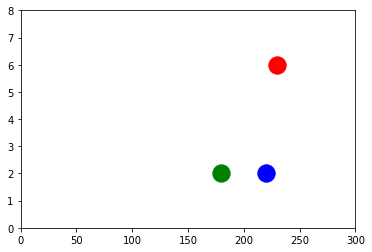

In [23]:
a = np.array([180,2])
b = np.array([220,2])
c = np.array([230,6])

plt.xlim([0,300])
plt.ylim([0,8])
plt.scatter(a[0], a[1],  marker = 'o', c = 'g', s=300)
plt.scatter(b[0], b[1],  marker = 'o', c = 'b', s=300)
plt.scatter(c[0], c[1],  marker = 'o', c = 'r', s=300)

In [24]:
print('Error of green to blue: '+ str(calculate_error(a,b)))
print('Error of red to blue: '+ str(calculate_error(c,b))) 

Error of green to blue: 2560000
Error of red to blue: 13456


In [25]:
def normalize(x):
    return (x-x.min())/(x.max()-x.min())

temp_data = pd.DataFrame([a,b,c], columns = ['x','y'])
temp_data = temp_data.apply(normalize)

print('Error of green to blue(datos normalizados): '+ str(calculate_error(temp_data.loc[0],temp_data.loc[1])))
print('Error of red to blue(datos normalizados): '+ str(calculate_error(temp_data.loc[2],temp_data.loc[1])))

Error of green to blue(datos normalizados): 0.4096000000000002
Error of red to blue(datos normalizados): 1.0816000000000001


<ipython-input-21-e0c94d0de566>:25: UserWarning: Cluster devanished! Consider reducing the number of k
  warnings.warn("Cluster devanished! Consider reducing the number of k")


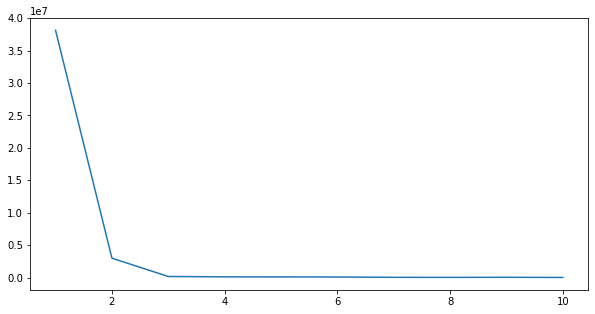

In [26]:
total_errors = []
n = 10

for i in range(n):
    _,it_error, _ = knn(data.drop(['centroid','error'], axis = 1),i+1) 
    total_errors.append(it_error)

plt.figure(figsize=(10,5))
plt.plot(range(1,11), total_errors )